In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchinfo

In [3]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Already exists")
else:
  print("Download helper_functions.py")
  request = requests.get(f"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Download helper_functions.py


In [4]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from torch import nn
import helper_functions
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
import requests
import zipfile
import io
from pathlib import Path

In [8]:
url = "https://zenodo.org/records/4002935/files/hirise-map-proj-v3_2.zip?download=1"
response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
else:
    print(f"Download failed with status code: {response.status_code}")
    exit()
in_memory_file = io.BytesIO(response.content)
with zipfile.ZipFile(in_memory_file, 'r') as zip_ref:
    zip_ref.extractall()

Download successful!


In [9]:
from helper_functions import walk_through_dir

data_dir = r"/kaggle/working/hirise-map-proj-v3_2"
walk_through_dir(data_dir)

There are 1 directories and 3 images in '/kaggle/working/hirise-map-proj-v3_2'.
There are 0 directories and 64947 images in '/kaggle/working/hirise-map-proj-v3_2/map-proj-v3_2'.


In [10]:
import os

image_folder_path = r'/kaggle/working/hirise-map-proj-v3_2/map-proj-v3_2'

all_files = os.listdir(image_folder_path)

data_images = []
data_labels = []

In [11]:
os.chdir(r"/kaggle/working/hirise-map-proj-v3_2/map-proj-v3_2")

In [12]:
with open(r'/kaggle/working/hirise-map-proj-v3_2/labels-map-proj_v3_2.txt') as labels:
  for line in labels:
    file_name, label = line.split(' ')
    if os.path.isfile(os.path.join(image_folder_path, file_name)):
      #print("File exists and is getting appended to data_images along with its labels in data_labels")
      data_images.append(file_name)
      data_labels.append(int(label))

In [13]:
import pandas as pd
df = pd.read_csv(r"/kaggle/working/hirise-map-proj-v3_2/landmarks_map-proj-v3_2_classmap.csv",index_col=0)
df

,other
0,
1,crater
2,dark dune
3,slope streak
4,bright dune
5,impact ejecta
6,swiss cheese
7,spider


In [14]:
class_names = ['other','crater','dark dune','slope streak',
                'bright dune','impact ejecta','swiss cheese','spider']
for i in range(len(class_names)):
  print(f"No. of images in data_set in class {class_names[i]} : {data_labels.count(i)}")

No. of images in data_set in class other : 52722
No. of images in data_set in class crater : 5024
No. of images in data_set in class dark dune : 766
No. of images in data_set in class slope streak : 1575
No. of images in data_set in class bright dune : 1654
No. of images in data_set in class impact ejecta : 476
No. of images in data_set in class swiss cheese : 1834
No. of images in data_set in class spider : 896


In [15]:
total_images_excluding_other = len(data_labels) - data_labels.count(0)
desired_images_per_class = int(total_images_excluding_other / len(class_names))
total_images_excluding_other, desired_images_per_class

(12225, 1528)

In [16]:
data_set = {}
data_set["file_names"] = data_images
data_set["labels"] = data_labels

In [17]:
df = pd.DataFrame.from_dict(data_set)
df.head()

,file_names,labels
0,ESP_013049_0950_RED-0067.jpg,7
1,ESP_013049_0950_RED-0067-fv.jpg,7
2,ESP_013049_0950_RED-0067-brt.jpg,7
3,ESP_013049_0950_RED-0067-r90.jpg,7
4,ESP_013049_0950_RED-0067-r180.jpg,7


# Downsampling

In [18]:
from sklearn.utils import resample
df_1 = df[df['labels'] == 0]
df_2 = df[df['labels'] != 0]
df_1_downsample = resample(df_1,random_state=42,n_samples=1000,replace=True)

#concatenate the upsampled dataframe
df_downsample = pd.concat([df_1_downsample, df_2]).reset_index(drop=True)
df = df_downsample
df
from sklearn.utils import resample
df_1 = df[df['labels'] == 1]
df_2 = df[df['labels'] != 1]
df_1_downsample = resample(df_1,random_state=42,n_samples=1700,replace=True)

#concatenate the upsampled dataframe
df_downsample = pd.concat([df_1_downsample, df_2]).reset_index(drop=True)
df = df_downsample
df

,file_names,labels
0,ESP_026472_1410_RED-0372-brt.jpg,1
1,PSP_002776_2025_RED-0085-brt.jpg,1
2,ESP_029782_2075_RED-0746-fv.jpg,1
3,ESP_034590_1795_RED-0162-r180.jpg,1
4,ESP_016607_2080_RED-0264-r180.jpg,1
...,...,...
9896,PSP_004673_0935_RED-0091.jpg,6
9897,PSP_004673_0935_RED-0140.jpg,6
9898,PSP_004673_0935_RED-0070.jpg,6
9899,PSP_004673_0935_RED-0047.jpg,6


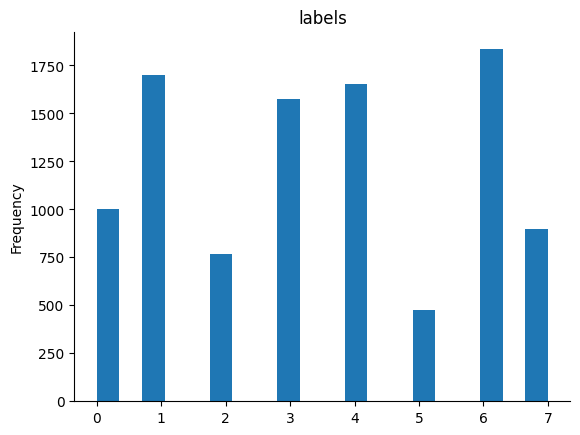

In [19]:
# @title labels

from matplotlib import pyplot as plt
df_downsample['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
X, y = df["file_names"], df["labels"]
X, y = (X).to_list(), y.to_list()
X[:5], y[:5]

(['ESP_026472_1410_RED-0372-brt.jpg',
  'PSP_002776_2025_RED-0085-brt.jpg',
  'ESP_029782_2075_RED-0746-fv.jpg',
  'ESP_034590_1795_RED-0162-r180.jpg',
  'ESP_016607_2080_RED-0264-r180.jpg'],
 [1, 1, 1, 1, 1])

In [21]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(7920, 1981, 7920, 1981)

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_list, label_list, device, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_list = label_list
        self.parsed_image_list = []
        for i in self.image_list:
            i = self.parse_image(i)
            i = i.convert('RGB')  # Convert grayscale image to RGB
            self.parsed_image_list.append(i)
        
      # Read a PIL image
    def parse_image(self, image_file):
        image = Image.open(image_file)
        return image

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        return self.parsed_image_list[idx], self.label_list[idx]

In [23]:
# Define transforms for training
transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [0, 1]
])


# Create datasets
train_dataset = ImageDataset(X_train, y_train, transform=None, device=device)
test_dataset = ImageDataset(X_test, y_test, transform=None, device=device)

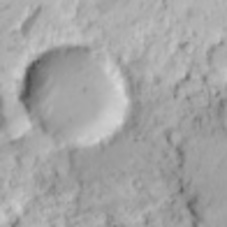

In [24]:
train_dataset[0][0]

In [25]:
from transformers import AutoImageProcessor
model_name = r"microsoft/swinv2-tiny-patch4-window8-256"
processor = AutoImageProcessor.from_pretrained(model_name, return_tensors = 'pt')

def apply_processor(img, label):
    inputs = {}
    inputs['pixel_values'] = processor(img, return_tensors="pt").pixel_values.squeeze()
    inputs["label"] = label
    return inputs

#processed_dataset = X_train.map(apply_processor)

2024-05-27 13:06:44.221459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 13:06:44.221715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 13:06:44.410238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [26]:
train_input_array = []
for i in range(len(train_dataset)):
    train_input_array.append(apply_processor(train_dataset[i][0], train_dataset[i][1]))

In [27]:
test_input_array = []
for i in range(len(test_dataset)):
    test_input_array.append(apply_processor(test_dataset[i][0], test_dataset[i][1]))

In [28]:
# Assuming you have 7 classes
custom_id2label = {i: class_name for i, class_name in enumerate(class_names)}
custom_label2id = {class_name: i for i, class_name in enumerate(class_names)}

custom_id2label, custom_label2id

({0: 'other',
  1: 'crater',
  2: 'dark dune',
  3: 'slope streak',
  4: 'bright dune',
  5: 'impact ejecta',
  6: 'swiss cheese',
  7: 'spider'},
 {'other': 0,
  'crater': 1,
  'dark dune': 2,
  'slope streak': 3,
  'bright dune': 4,
  'impact ejecta': 5,
  'swiss cheese': 6,
  'spider': 7})

In [29]:
from transformers import Swinv2ForImageClassification
model = Swinv2ForImageClassification.from_pretrained(model_name,
                                                  id2label=custom_id2label,
                                                  label2id=custom_label2id,
                                                  ignore_mismatched_sizes=True)
processor = AutoImageProcessor.from_pretrained(model_name, do_rescale = False, return_tensors = 'pt')

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor c

In [30]:
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, cohen_kappa_score
from sklearn.utils.multiclass import unique_labels

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  # Basic metrics
  accuracy = accuracy_score(predictions, labels)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

  # Confusion Matrix
  confusion_matrix_ = confusion_matrix(labels, predictions)

  # Class-balanced Accuracy (assuming unique labels)
  class_balanced_accuracy = np.mean(np.diag(confusion_matrix_) / np.sum(confusion_matrix_, axis=1))


  # Kappa Statistic
  kappa = cohen_kappa_score(labels, predictions)

  # ROC Curve (requires probability estimates)
  if hasattr(eval_pred, "predictions"):
    if hasattr(eval_pred.predictions, "predictions"):
      # Assuming predictions contain probabilities
      roc_auc = roc_auc_score(labels, eval_pred.predictions.predictions[:, 1])  # Assuming second column is positive class probability
    else:
      roc_auc = None
  else:
    roc_auc = None

  # Combine all metrics
  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "confusion_matrix": confusion_matrix_.tolist(),  # Convert to list for serialization
      "class_balanced_accuracy": class_balanced_accuracy,
      "kappa": kappa,
      "ROC_AUC": roc_auc
  }


In [31]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# TrainingArguments and Trainer

In [32]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

# Define Train Parameters
args = TrainingArguments(
    f"HiRise-SwinV2-classification",
    use_cpu = False,
    evaluation_strategy="steps",
    logging_steps = 100,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [33]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_input_array,
    eval_dataset=test_input_array,
    tokenizer=processor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [34]:
os.chdir("/kaggle/working/")
os.mkdir("models")
model_dir = "/kaggle/working/models/"

In [35]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model(model_dir + "HiRise_SwinV2")
#trainer.log_metrics("train", train_results.metrics)
#trainer.save_metrics(split="train", metrics=train_results.metrics)
# save the trainer state
#trainer.save_state()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix,Class Balanced Accuracy,Kappa,Roc Auc
100,0.644000,0.181607,0.944472,0.943455,0.944472,0.943655,"[[151, 12, 1, 12, 0, 4, 4, 3], [4, 347, 0, 2, 0, 3, 0, 0], [2, 2, 146, 0, 1, 0, 3, 2], [1, 3, 0, 303, 0, 1, 0, 1], [0, 0, 0, 0, 341, 0, 0, 0], [9, 1, 0, 1, 0, 84, 0, 16], [0, 0, 5, 0, 0, 0, 346, 0], [5, 0, 0, 0, 2, 10, 0, 153]]",0.917650,0.935107,None
200,0.170200,0.130562,0.961131,0.960527,0.961131,0.960532,"[[156, 15, 0, 9, 0, 3, 3, 1], [1, 355, 0, 0, 0, 0, 0, 0], [0, 0, 151, 0, 0, 1, 2, 2], [1, 2, 0, 305, 0, 1, 0, 0], [0, 0, 0, 0, 341, 0, 0, 0], [9, 0, 0, 0, 0, 92, 0, 10], [0, 0, 5, 0, 0, 0, 346, 0], [4, 0, 0, 0, 0, 8, 0, 158]]",0.941302,0.954580,None
300,0.125700,0.115486,0.967693,0.967492,0.967693,0.967253,"[[163, 11, 0, 8, 0, 2, 2, 1], [5, 351, 0, 0, 0, 0, 0, 0], [0, 0, 151, 0, 0, 0, 3, 2], [1, 1, 0, 307, 0, 0, 0, 0], [0, 0, 0, 0, 341, 0, 0, 0], [6, 0, 0, 0, 0, 92, 0, 13], [0, 0, 3, 0, 0, 0, 348, 0], [1, 0, 0, 0, 0, 5, 0, 164]]",0.950510,0.962256,None


Trainer is attempting to log a value of "[[151, 12, 1, 12, 0, 4, 4, 3], [4, 347, 0, 2, 0, 3, 0, 0], [2, 2, 146, 0, 1, 0, 3, 2], [1, 3, 0, 303, 0, 1, 0, 1], [0, 0, 0, 0, 341, 0, 0, 0], [9, 1, 0, 1, 0, 84, 0, 16], [0, 0, 5, 0, 0, 0, 346, 0], [5, 0, 0, 0, 2, 10, 0, 153]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/ROC_AUC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[156, 15, 0, 9, 0, 3, 3, 1], [1, 355, 0, 0, 

In [36]:
os.chdir("/kaggle/working/")

In [37]:
swin_metrics = trainer.evaluate()
swin_metrics["Model_Name"] = "SwinV2-HiRise"
swin_metrics
swin_metrics = {"Model_5_Metrics" : swin_metrics}
swin_metrics

Trainer is attempting to log a value of "[[163, 11, 0, 8, 0, 2, 2, 1], [4, 352, 0, 0, 0, 0, 0, 0], [0, 0, 151, 0, 0, 0, 3, 2], [1, 1, 0, 307, 0, 0, 0, 0], [0, 0, 0, 0, 341, 0, 0, 0], [6, 0, 0, 0, 0, 92, 0, 13], [0, 0, 3, 0, 0, 0, 348, 0], [1, 0, 0, 0, 0, 5, 0, 164]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/ROC_AUC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'Model_5_Metrics': {'eval_loss': 0.11534728109836578,
  'eval_accuracy': 0.9681978798586572,
  'eval_precision': 0.9680075879286224,
  'eval_recall': 0.9681978798586572,
  'eval_f1': 0.9677421839905463,
  'eval_confusion_matrix': [[163, 11, 0, 8, 0, 2, 2, 1],
   [4, 352, 0, 0, 0, 0, 0, 0],
   [0, 0, 151, 0, 0, 0, 3, 2],
   [1, 1, 0, 307, 0, 0, 0, 0],
   [0, 0, 0, 0, 341, 0, 0, 0],
   [6, 0, 0, 0, 0, 92, 0, 13],
   [0, 0, 3, 0, 0, 0, 348, 0],
   [1, 0, 0, 0, 0, 5, 0, 164]],
  'eval_class_balanced_accuracy': 0.9508607159535762,
  'eval_kappa': 0.9628443070987103,
  'eval_ROC_AUC': None,
  'eval_runtime': 7.8852,
  'eval_samples_per_second': 251.229,
  'eval_steps_per_second': 2.029,
  'epoch': 5.0,
  'Model_Name': 'SwinV2-HiRise'}}

In [38]:
#Convert and write JSON object to file
import json 
with open("swin_metrics.json", "w") as outfile: 
    json.dump(swin_metrics, outfile)
swin_metrics_loaded = pd.read_json("/kaggle/working/swin_metrics.json", orient="index")
swin_metrics_loaded

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_confusion_matrix,eval_class_balanced_accuracy,eval_kappa,eval_ROC_AUC,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Model_Name
Model_5_Metrics,0.115347,0.968198,0.968008,0.968198,0.967742,"[[163, 11, 0, 8, 0, 2, 2, 1], [4, 352, 0, 0, 0...",0.950861,0.962844,NaN,7.8852,251.229,2.029,5,SwinV2-HiRise


# Visualize and evaluate predictions of the model

In [55]:
test_imgs = []
test_labels = []
for i in test_input_array[:16]:
    test_imgs.append(i["pixel_values"])
    test_labels.append(i["label"])

In [56]:
test_imgs[0], test_labels[0]

(tensor([[[ 0.3823,  0.3481,  0.3309,  ...,  0.3823,  0.3823,  0.3823],
          [ 0.3652,  0.3481,  0.3652,  ...,  0.3994,  0.3994,  0.3994],
          [ 0.3481,  0.3652,  0.3823,  ...,  0.4166,  0.4166,  0.4166],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.2796,  0.2796,  0.2796],
          [-2.1179, -2.1179, -2.1179,  ...,  0.2796,  0.2796,  0.2796],
          [-2.1179, -2.1179, -2.1179,  ...,  0.2796,  0.2796,  0.2796]],
 
         [[ 0.5203,  0.4853,  0.4678,  ...,  0.5203,  0.5203,  0.5203],
          [ 0.5028,  0.4853,  0.5028,  ...,  0.5378,  0.5378,  0.5378],
          [ 0.4853,  0.5028,  0.5203,  ...,  0.5553,  0.5553,  0.5553],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.4153,  0.4153,  0.4153],
          [-2.0357, -2.0357, -2.0357,  ...,  0.4153,  0.4153,  0.4153],
          [-2.0357, -2.0357, -2.0357,  ...,  0.4153,  0.4153,  0.4153]],
 
         [[ 0.7402,  0.7054,  0.6879,  ...,  0.7402,  0.7402,  0.7402],
          [ 0.7228,  0.7054,

In [57]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [58]:
pred_probs = make_predictions(model=loaded_model,
                              data=test_imgs)
pred_probs

tensor([[1.2666e-05, 2.6557e-07, 1.4697e-04, 1.9351e-07, 5.5806e-07, 4.7436e-07,
         9.9984e-01, 4.2045e-07],
        [9.7991e-04, 8.8731e-05, 2.5836e-03, 7.6627e-06, 6.7273e-06, 2.2357e-06,
         9.9633e-01, 6.3016e-07],
        [6.1155e-07, 1.1927e-06, 1.3232e-05, 1.8553e-07, 9.9998e-01, 1.8368e-07,
         1.4964e-07, 1.9402e-06],
        [2.3057e-03, 5.4088e-05, 8.3369e-05, 9.9738e-01, 1.0516e-06, 1.0539e-04,
         6.3634e-05, 4.0187e-06],
        [6.2073e-05, 9.9991e-01, 6.8464e-07, 3.4303e-08, 1.1771e-05, 1.4562e-05,
         1.7801e-06, 1.3118e-07],
        [5.6956e-03, 5.8542e-05, 8.7895e-05, 2.8501e-07, 3.2114e-05, 5.2816e-05,
         9.9407e-01, 4.8507e-06],
        [1.8507e-03, 2.4949e-04, 1.6282e-04, 5.1328e-04, 6.5715e-05, 1.7598e-01,
         2.4871e-05, 8.2116e-01],
        [8.6992e-05, 2.0732e-05, 2.0608e-04, 8.2373e-06, 1.1511e-06, 1.8082e-06,
         9.9967e-01, 7.8643e-08],
        [1.0940e-04, 5.2924e-05, 1.6622e-04, 2.0853e-05, 3.1823e-05, 6.3365e-01,

In [59]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([6, 6, 4, 3, 1, 6, 7, 6, 5, 5, 7, 2, 1, 0, 6, 0]),
 [6, 6, 4, 3, 1, 6, 7, 6, 5, 2, 7, 2, 1, 0, 6, 0])

In [60]:
test_imgs[0].shape

torch.Size([3, 256, 256])

In [61]:
image = test_imgs[0][-1, :, :]
image.shape

torch.Size([256, 256])

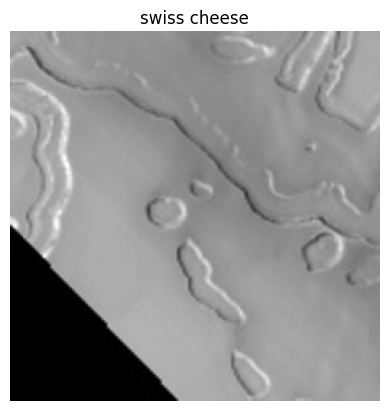

In [62]:
plt.imshow(test_imgs[0][-1, :, :], cmap="gray")
plt.title(class_names[test_labels[0]])
plt.axis(False);

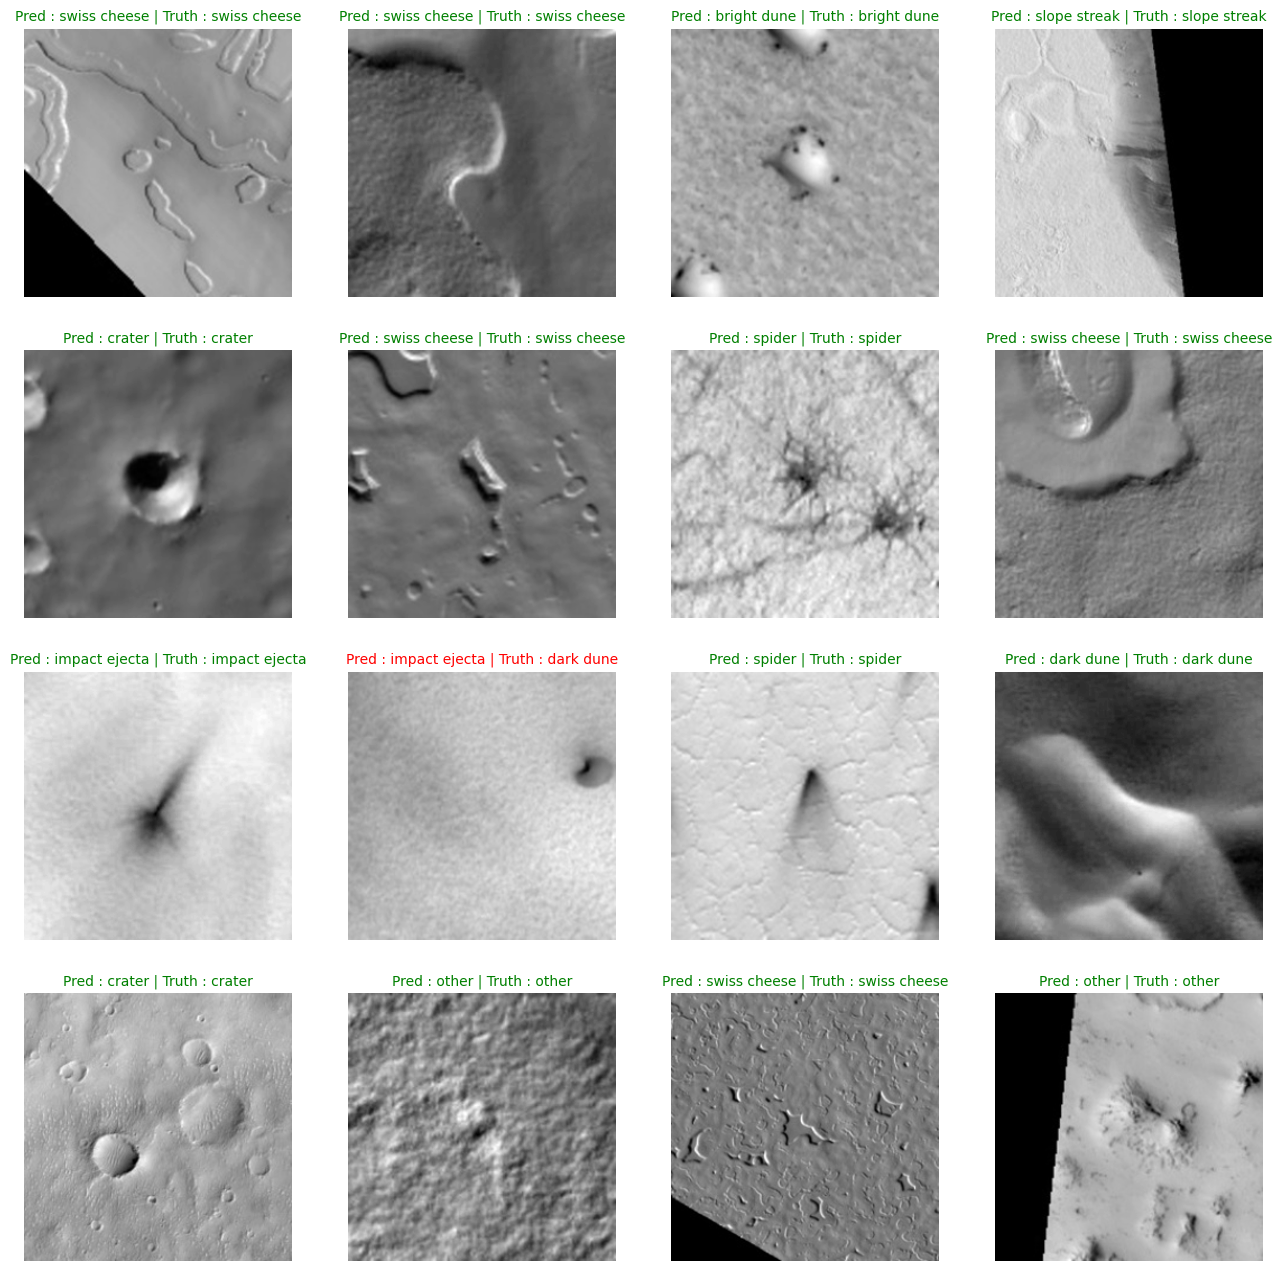

In [63]:
plt.figure(figsize=(16, 16))
nrows, ncols = 4, 4
for i, sample in enumerate(test_imgs):
    plt.subplot(nrows, ncols, i+1)
    sample = sample[-1, :, :]
    plt.imshow(sample.squeeze(), cmap = "gray")
    plt.axis(False);
    
    pred_label = class_names[pred_classes[i]]
    
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred : {pred_label} | Truth : {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    
    else:
        plt.title(title_text, fontsize=10, c="r")